# Explore NHANES

This is a first swing at exploring NHANES datasets. Currently just working with the 2021-2023 survey and only using day 1 of the dietary recalls. 

## Check and set working directory (colab)

I'm not really sure this is necessary, the colab environment is confusing. And I'm also not sure whether we need to mount the drive in every session.

In [ ]:
# Check current working directory.
!pwd

In [ ]:
# If pwd does not lead to ds1_nhanes folder, set it here
# Move working directory to ds1_nhanes folder
%cd /content/drive/MyDrive/ds1_nhanes/
!pwd

In [316]:
# For local use only, not Colab

# import os
# from pathlib import Path
# os.chdir(Path(os.getcwd()).parent)
# print(os.getcwd())

## Load Data and Libraries

In [317]:
import pandas as pd
import numpy as np

In [318]:
# Load daily recall 1 individual foods data
df = pd.read_sas('data/raw/nhanes_2021_2023/DR1IFF_L.xpt')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100116 entries, 0 to 100115
Data columns (total 84 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   SEQN      100116 non-null  float64
 1   WTDRD1    100116 non-null  float64
 2   WTDR2D    100116 non-null  float64
 3   DR1ILINE  100116 non-null  float64
 4   DR1DRSTZ  100116 non-null  float64
 5   DR1EXMER  100116 non-null  float64
 6   DRABF     99847 non-null   float64
 7   DRDINT    100116 non-null  float64
 8   DR1DBIH   94128 non-null   float64
 9   DR1DAY    100116 non-null  float64
 10  DR1LANG   100025 non-null  float64
 11  DR1CCMNM  100116 non-null  float64
 12  DR1CCMTX  100116 non-null  float64
 13  DR1_020   100116 non-null  float64
 14  DR1_030Z  100116 non-null  float64
 15  DR1FS     92784 non-null   float64
 16  DR1_040Z  99787 non-null   float64
 17  DR1IFDCD  100116 non-null  float64
 18  DR1IGRMS  99787 non-null   float64
 19  DR1IKCAL  99787 non-null   float64
 20  DR1I

## Create dictionary for DR1IFF

This will define each variable. We could rename them, but I found that it just makes it harder when we have to join across multiple waves.

In [319]:
# Get a printout of each column name as a template
# We will copy and paste this into next cell so we can write definitions
column_definitions = {col: "" for col in df.columns}
for col in column_definitions:
    print(f'"{col}": "",  # ')

"SEQN": "",  # 
"WTDRD1": "",  # 
"WTDR2D": "",  # 
"DR1ILINE": "",  # 
"DR1DRSTZ": "",  # 
"DR1EXMER": "",  # 
"DRABF": "",  # 
"DRDINT": "",  # 
"DR1DBIH": "",  # 
"DR1DAY": "",  # 
"DR1LANG": "",  # 
"DR1CCMNM": "",  # 
"DR1CCMTX": "",  # 
"DR1_020": "",  # 
"DR1_030Z": "",  # 
"DR1FS": "",  # 
"DR1_040Z": "",  # 
"DR1IFDCD": "",  # 
"DR1IGRMS": "",  # 
"DR1IKCAL": "",  # 
"DR1IPROT": "",  # 
"DR1ICARB": "",  # 
"DR1ISUGR": "",  # 
"DR1IFIBE": "",  # 
"DR1ITFAT": "",  # 
"DR1ISFAT": "",  # 
"DR1IMFAT": "",  # 
"DR1IPFAT": "",  # 
"DR1ICHOL": "",  # 
"DR1IATOC": "",  # 
"DR1IATOA": "",  # 
"DR1IRET": "",  # 
"DR1IVARA": "",  # 
"DR1IACAR": "",  # 
"DR1IBCAR": "",  # 
"DR1ICRYP": "",  # 
"DR1ILYCO": "",  # 
"DR1ILZ": "",  # 
"DR1IVB1": "",  # 
"DR1IVB2": "",  # 
"DR1INIAC": "",  # 
"DR1IVB6": "",  # 
"DR1IFOLA": "",  # 
"DR1IFA": "",  # 
"DR1IFF": "",  # 
"DR1IFDFE": "",  # 
"DR1ICHL": "",  # 
"DR1IVB12": "",  # 
"DR1IB12A": "",  # 
"DR1IVC": "",  # 
"DR1IVD": "",  # 
"DR1IVK": "",  #

In [320]:
column_definitions = {
  "SEQN": "respondent_id",
  "WTDRD1": "weight_day_1_dietary",
  "WTDR2D": "weight_day_2_dietary",
  "DR1ILINE": "food_component_number",
  "DR1DRSTZ": "dietary_recall_status",
  "DR1EXMER": "interviewer_id_code",
  "DRABF": "breast_fed_infant",
  "DRDINT": "number_of_days_intake",
  "DR1DBIH": "days_between_intake_and_interview",
  "DR1DAY": "intake_day_of_week",
  "DR1LANG": "langauge",
  "DR1CCMNM": "combination_food_number",
  "DR1CCMTX": "combination_food_type",
  "DR1_020": "time_of_meal",
  "DR1_030Z": "name_of_meal",
  "DR1FS": "food_source",
  "DR1_040Z": "ate_at_home",
  "DR1IFDCD": "usda_food_code",
  "DR1IGRMS": "",
  "DR1IKCAL": "",
  "DR1IPROT": "",
  "DR1ICARB": "",
  "DR1ISUGR": "",
  "DR1IFIBE": "",
  "DR1ITFAT": "",
  "DR1ISFAT": "",
  "DR1IMFAT": "",
  "DR1IPFAT": "",
  "DR1ICHOL": "",
  "DR1IATOC": "",
  "DR1IATOA": "",
  "DR1IRET": "",
  "DR1IVARA": "",
  "DR1IACAR": "",
  "DR1IBCAR": "",
  "DR1ICRYP": "",
  "DR1ILYCO": "",
  "DR1ILZ": "",
  "DR1IVB1": "",
  "DR1IVB2": "",
  "DR1INIAC": "",
  "DR1IVB6": "",
  "DR1IFOLA": "",
  "DR1IFA": "",
  "DR1IFF": "",
  "DR1IFDFE": "",
  "DR1ICHL": "",
  "DR1IVB12": "",
  "DR1IB12A": "",
  "DR1IVC": "",
  "DR1IVD": "",
  "DR1IVK": "",
  "DR1ICALC": "",
  "DR1IPHOS": "",
  "DR1IMAGN": "",
  "DR1IIRON": "",
  "DR1IZINC": "",
  "DR1ICOPP": "",
  "DR1ISODI": "",
  "DR1IPOTA": "",
  "DR1ISELE": "",
  "DR1ICAFF": "",
  "DR1ITHEO": "",
  "DR1IALCO": "",
  "DR1IMOIS": "",
  "DR1IS040": "",
  "DR1IS060": "",
  "DR1IS080": "",
  "DR1IS100": "",
  "DR1IS120": "",
  "DR1IS140": "",
  "DR1IS160": "",
  "DR1IS180": "",
  "DR1IM161": "",
  "DR1IM181": "",
  "DR1IM201": "",
  "DR1IM221": "",
  "DR1IP182": "",
  "DR1IP183": "",
  "DR1IP184": "",
  "DR1IP204": "",
  "DR1IP205": "",
  "DR1IP225": "",
  "DR1IP226": ""
}

In [321]:
df.columns

Index(['SEQN', 'WTDRD1', 'WTDR2D', 'DR1ILINE', 'DR1DRSTZ', 'DR1EXMER', 'DRABF',
       'DRDINT', 'DR1DBIH', 'DR1DAY', 'DR1LANG', 'DR1CCMNM', 'DR1CCMTX',
       'DR1_020', 'DR1_030Z', 'DR1FS', 'DR1_040Z', 'DR1IFDCD', 'DR1IGRMS',
       'DR1IKCAL', 'DR1IPROT', 'DR1ICARB', 'DR1ISUGR', 'DR1IFIBE', 'DR1ITFAT',
       'DR1ISFAT', 'DR1IMFAT', 'DR1IPFAT', 'DR1ICHOL', 'DR1IATOC', 'DR1IATOA',
       'DR1IRET', 'DR1IVARA', 'DR1IACAR', 'DR1IBCAR', 'DR1ICRYP', 'DR1ILYCO',
       'DR1ILZ', 'DR1IVB1', 'DR1IVB2', 'DR1INIAC', 'DR1IVB6', 'DR1IFOLA',
       'DR1IFA', 'DR1IFF', 'DR1IFDFE', 'DR1ICHL', 'DR1IVB12', 'DR1IB12A',
       'DR1IVC', 'DR1IVD', 'DR1IVK', 'DR1ICALC', 'DR1IPHOS', 'DR1IMAGN',
       'DR1IIRON', 'DR1IZINC', 'DR1ICOPP', 'DR1ISODI', 'DR1IPOTA', 'DR1ISELE',
       'DR1ICAFF', 'DR1ITHEO', 'DR1IALCO', 'DR1IMOIS', 'DR1IS040', 'DR1IS060',
       'DR1IS080', 'DR1IS100', 'DR1IS120', 'DR1IS140', 'DR1IS160', 'DR1IS180',
       'DR1IM161', 'DR1IM181', 'DR1IM201', 'DR1IM221', 'DR1IP182', 'DR1IP183',

In [322]:
# Make a df with column names and definitions
long_names = [
    'respondent_sequence_number', # respondent id
    'weight_day_1_dietary',
    'weight_day_2_dietary',
    'food_component_number',
    'dietary_recall_status',
    'interviewer_id_code',
    'breast_fed_infant',
    'number_of_days_of_intake',
    'days_between_intake_and_interview',
    'intake_day_of_week',

    'language',
    'combination_food_number',
    'combination_food_type',
    'time_of_meal',
    'name_of_meal',
    'food_source',
    'ate_at_home',
    'usda_food_code', # Use these to link to FPED
    'grams',
    'energy_kcal',

    'protein_gm',
    'carbohydrate_gm',
    'sugar_gm',
    'fiber_gm',
    'fat_gm',
    'saturated_fat_gm',
    'monounsaturated_fat_gm',
    'polyunsaturated_fat_gm',
    'cholesterol_mg',
    'vitamin_e_mcg',

    'added_vitamin_e_mcg',
    'retinol_mcg',
    'vitamin_a_mcg',
    'alpha_carotene_mcg',
    'beta_carotene_mcg',
    'beta_cryptoxanthin_mcg',
    'lycopene_mcg',
    'lutein_zeaxanthin_mcg',
    'vitamin_b1_mcg',
    'vitamin_b2_mcg',

    'niacin_mg',
    'vitamin_b6_mcg',
    'folate_mcg',
    'folic_acid_mcg',
    'food_folate_mcg',
    'folate_dfe_mcg',
    'choline_mg',
    'vitamin_b12_mcg',
    'added_vitamin_b12_mcg',
    'vitamin_c_mg',

    'vitamin_d_mcg',
    'vitamin_k_mcg',
    'calcium_mg',
    'phosphorus_mg',
    'magnesium_mg',
    'iron_mg',
    'zinc_mg',
    'copper_mg',
    'sodium_mg',
    'potassium_mg',

    'selenium_mcg',
    'caffeine_mg',
    'theobromine_mg',
    'alcohol_gm',
    'moisture_gm',
    'sfa_40_gm',
    'sfa_60_gm',
    'sfa_80_gm',
    'sfa_100_gm',
    'sfa_120_gm',

    'sfa_140_gm',
    'sfa_160_gm',
    'sfa_180_gm',
    'mfa_161_gm',
    'mfa_181_gm',
    'mfa_201_gm',
    'mfa_221_gm',
    'pfa_182_gm',
    'pfa_183_gm',
    'pfa_184_gm',

    'pfa_204_gm',
    'pfa_205_gm',
    'pfa_225_gm',
    'pfa_226_gm'
]
print(long_names)

['respondent_sequence_number', 'weight_day_1_dietary', 'weight_day_2_dietary', 'food_component_number', 'dietary_recall_status', 'interviewer_id_code', 'breast_fed_infant', 'number_of_days_of_intake', 'days_between_intake_and_interview', 'intake_day_of_week', 'language', 'combination_food_number', 'combination_food_type', 'time_of_meal', 'name_of_meal', 'food_source', 'ate_at_home', 'usda_food_code', 'grams', 'energy_kcal', 'protein_gm', 'carbohydrate_gm', 'sugar_gm', 'fiber_gm', 'fat_gm', 'saturated_fat_gm', 'monounsaturated_fat_gm', 'polyunsaturated_fat_gm', 'cholesterol_mg', 'vitamin_e_mcg', 'added_vitamin_e_mcg', 'retinol_mcg', 'vitamin_a_mcg', 'alpha_carotene_mcg', 'beta_carotene_mcg', 'beta_cryptoxanthin_mcg', 'lycopene_mcg', 'lutein_zeaxanthin_mcg', 'vitamin_b1_mcg', 'vitamin_b2_mcg', 'niacin_mg', 'vitamin_b6_mcg', 'folate_mcg', 'folic_acid_mcg', 'food_folate_mcg', 'folate_dfe_mcg', 'choline_mg', 'vitamin_b12_mcg', 'added_vitamin_b12_mcg', 'vitamin_c_mg', 'vitamin_d_mcg', 'vitam

In [323]:
definitions = pd.DataFrame({'variable_name': df.columns, 'definition': long_names})
definitions.head()

,variable_name,definition
0,SEQN,respondent_sequence_number
1,WTDRD1,weight_day_1_dietary
2,WTDR2D,weight_day_2_dietary
3,DR1ILINE,food_component_number
4,DR1DRSTZ,dietary_recall_status


In [324]:
# Save definitions to objects folder
definitions.to_csv('data/miscellany/dr1_definitions_2021.csv')

## Explore Dietary Recall Data

In [325]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100116 entries, 0 to 100115
Data columns (total 84 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   SEQN      100116 non-null  float64
 1   WTDRD1    100116 non-null  float64
 2   WTDR2D    100116 non-null  float64
 3   DR1ILINE  100116 non-null  float64
 4   DR1DRSTZ  100116 non-null  float64
 5   DR1EXMER  100116 non-null  float64
 6   DRABF     99847 non-null   float64
 7   DRDINT    100116 non-null  float64
 8   DR1DBIH   94128 non-null   float64
 9   DR1DAY    100116 non-null  float64
 10  DR1LANG   100025 non-null  float64
 11  DR1CCMNM  100116 non-null  float64
 12  DR1CCMTX  100116 non-null  float64
 13  DR1_020   100116 non-null  float64
 14  DR1_030Z  100116 non-null  float64
 15  DR1FS     92784 non-null   float64
 16  DR1_040Z  99787 non-null   float64
 17  DR1IFDCD  100116 non-null  float64
 18  DR1IGRMS  99787 non-null   float64
 19  DR1IKCAL  99787 non-null   float64
 20  DR1I

In [326]:
# Compare rows to unique respondent IDs
# first get number of rows
print(df.shape)
print(df['SEQN'].nunique())

(100116, 84)
6751


There are far more rows than unique respondents. This is because for each respondent, there is one row for each individual food they consumed.

In [327]:
# Get unique food codes
print(df['DR1IFDCD'].nunique())

3987


## Join with FPED

To identify the foods from food codes, we join with the Food Patterns Equivalents Database. This also links it to the ~39 USDA food categories that correspond to national dietary recommendations. It also converts from sensible units like grams to American units like cups.

In [328]:
fped = pd.read_csv('data/miscellany/FPED_1720.csv')
fped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7444 entries, 0 to 7443
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   FOODCODE                   7444 non-null   int64  
 1   DESCRIPTION                7444 non-null   object 
 2   F_TOTAL (cup eq)           7444 non-null   float64
 3   F_CITMLB (cup eq)          7444 non-null   float64
 4   F_OTHER (cup eq)           7444 non-null   float64
 5   F_JUICE (cup eq)           7444 non-null   float64
 6   V_TOTAL (cup eq)           7444 non-null   float64
 7   V_DRKGR (cup eq)           7444 non-null   float64
 8   V_REDOR_TOTAL (cup eq)     7444 non-null   float64
 9   V_REDOR_TOMATO (cup eq)    7444 non-null   float64
 10  V_REDOR_OTHER (cup eq)     7444 non-null   float64
 11  V_STARCHY_TOTAL (cup eq)   7444 non-null   float64
 12  V_STARCHY_POTATO (cup eq)  7444 non-null   float64
 13  V_STARCHY_OTHER (cup eq)   7444 non-null   float

In [329]:
# Get a list of relevant columns with beans, peas, or legumes
keywords = ['LEGUMES', 'NUTSDS', 'SOY']
bpl_columns = [col for col in fped.columns if any(keyword in col for keyword in keywords)]
print(bpl_columns)

['V_LEGUMES (cup eq)', 'PF_SOY (oz eq)', 'PF_NUTSDS (oz eq)', 'PF_LEGUMES (oz eq)']


In [330]:
# Get a list of food codes for BPLs where any one of those columns are > 0
condition = (fped[bpl_columns] > 0).any(axis=1)
bpl_codes = fped.loc[condition, 'FOODCODE']
print(bpl_codes)
# 800 codes out of 7381

31      11300100
38      11350000
39      11350010
40      11350020
41      11350030
          ...   
7362    95120000
7369    95201300
7370    95201500
7379    95220010
7381    95230010
Name: FOODCODE, Length: 800, dtype: int64


In [331]:
# Make a new column in dietary recall data that says whether each food is a BPL or not
df_bpl = df
df_bpl['is_bpl'] = df_bpl['DR1IFDCD'].isin(bpl_codes).astype(int)
df_bpl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100116 entries, 0 to 100115
Data columns (total 85 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   SEQN      100116 non-null  float64
 1   WTDRD1    100116 non-null  float64
 2   WTDR2D    100116 non-null  float64
 3   DR1ILINE  100116 non-null  float64
 4   DR1DRSTZ  100116 non-null  float64
 5   DR1EXMER  100116 non-null  float64
 6   DRABF     99847 non-null   float64
 7   DRDINT    100116 non-null  float64
 8   DR1DBIH   94128 non-null   float64
 9   DR1DAY    100116 non-null  float64
 10  DR1LANG   100025 non-null  float64
 11  DR1CCMNM  100116 non-null  float64
 12  DR1CCMTX  100116 non-null  float64
 13  DR1_020   100116 non-null  float64
 14  DR1_030Z  100116 non-null  float64
 15  DR1FS     92784 non-null   float64
 16  DR1_040Z  99787 non-null   float64
 17  DR1IFDCD  100116 non-null  float64
 18  DR1IGRMS  99787 non-null   float64
 19  DR1IKCAL  99787 non-null   float64
 20  DR1I

In [332]:
df_bpl.columns

Index(['SEQN', 'WTDRD1', 'WTDR2D', 'DR1ILINE', 'DR1DRSTZ', 'DR1EXMER', 'DRABF',
       'DRDINT', 'DR1DBIH', 'DR1DAY', 'DR1LANG', 'DR1CCMNM', 'DR1CCMTX',
       'DR1_020', 'DR1_030Z', 'DR1FS', 'DR1_040Z', 'DR1IFDCD', 'DR1IGRMS',
       'DR1IKCAL', 'DR1IPROT', 'DR1ICARB', 'DR1ISUGR', 'DR1IFIBE', 'DR1ITFAT',
       'DR1ISFAT', 'DR1IMFAT', 'DR1IPFAT', 'DR1ICHOL', 'DR1IATOC', 'DR1IATOA',
       'DR1IRET', 'DR1IVARA', 'DR1IACAR', 'DR1IBCAR', 'DR1ICRYP', 'DR1ILYCO',
       'DR1ILZ', 'DR1IVB1', 'DR1IVB2', 'DR1INIAC', 'DR1IVB6', 'DR1IFOLA',
       'DR1IFA', 'DR1IFF', 'DR1IFDFE', 'DR1ICHL', 'DR1IVB12', 'DR1IB12A',
       'DR1IVC', 'DR1IVD', 'DR1IVK', 'DR1ICALC', 'DR1IPHOS', 'DR1IMAGN',
       'DR1IIRON', 'DR1IZINC', 'DR1ICOPP', 'DR1ISODI', 'DR1IPOTA', 'DR1ISELE',
       'DR1ICAFF', 'DR1ITHEO', 'DR1IALCO', 'DR1IMOIS', 'DR1IS040', 'DR1IS060',
       'DR1IS080', 'DR1IS100', 'DR1IS120', 'DR1IS140', 'DR1IS160', 'DR1IS180',
       'DR1IM161', 'DR1IM181', 'DR1IM201', 'DR1IM221', 'DR1IP182', 'DR1IP183',

In [333]:
# Make another new column that just multiplies grams by is_bpl
# so it is 0 if not bpl, or the number of grams if it is
df_bpl['grams_bpl'] = np.where(df_bpl['is_bpl'] == True, df_bpl['DR1IGRMS'], 0)

In [334]:
# Let's just take SEQN, one day weights, food codes, grams, is_bpl, and grams bpl for now
# Then we will join this with demographics to look at BPL consumption
df_bpl = df_bpl[['SEQN', 'WTDRD1', 'DR1IFDCD', 'DR1IGRMS', 'is_bpl', 'grams_bpl']]
df_bpl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100116 entries, 0 to 100115
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   SEQN       100116 non-null  float64
 1   WTDRD1     100116 non-null  float64
 2   DR1IFDCD   100116 non-null  float64
 3   DR1IGRMS   99787 non-null   float64
 4   is_bpl     100116 non-null  int64  
 5   grams_bpl  100116 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 4.6 MB


## Add Demographics

In [335]:
demos = pd.read_sas('data/raw/nhanes_2021_2023/DEMO_L.xpt')
demos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11933 entries, 0 to 11932
Data columns (total 27 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      11933 non-null  float64
 1   SDDSRVYR  11933 non-null  float64
 2   RIDSTATR  11933 non-null  float64
 3   RIAGENDR  11933 non-null  float64
 4   RIDAGEYR  11933 non-null  float64
 5   RIDAGEMN  377 non-null    float64
 6   RIDRETH1  11933 non-null  float64
 7   RIDRETH3  11933 non-null  float64
 8   RIDEXMON  8860 non-null   float64
 9   RIDEXAGM  2787 non-null   float64
 10  DMQMILIZ  8301 non-null   float64
 11  DMDBORN4  11914 non-null  float64
 12  DMDYRUSR  1875 non-null   float64
 13  DMDEDUC2  7794 non-null   float64
 14  DMDMARTZ  7792 non-null   float64
 15  RIDEXPRG  1503 non-null   float64
 16  DMDHHSIZ  11933 non-null  float64
 17  DMDHRGND  4115 non-null   float64
 18  DMDHRAGZ  4124 non-null   float64
 19  DMDHREDZ  3746 non-null   float64
 20  DMDHRMAZ  4020 non-null   fl

In [336]:
# Let's take SEQN, age, gender, race, education, and ratio of family income to poverty
demos = demos[['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH3', 'DMDEDUC2', 'INDFMPIR']]
demos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11933 entries, 0 to 11932
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      11933 non-null  float64
 1   RIAGENDR  11933 non-null  float64
 2   RIDAGEYR  11933 non-null  float64
 3   RIDRETH3  11933 non-null  float64
 4   DMDEDUC2  7794 non-null   float64
 5   INDFMPIR  9892 non-null   float64
dtypes: float64(6)
memory usage: 559.5 KB


In [337]:
# Now join our demos with our DR1 data
joined = df_bpl.merge(demos, on='SEQN', how='left')
joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100116 entries, 0 to 100115
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   SEQN       100116 non-null  float64
 1   WTDRD1     100116 non-null  float64
 2   DR1IFDCD   100116 non-null  float64
 3   DR1IGRMS   99787 non-null   float64
 4   is_bpl     100116 non-null  int64  
 5   grams_bpl  100116 non-null  float64
 6   RIAGENDR   100116 non-null  float64
 7   RIDAGEYR   100116 non-null  float64
 8   RIDRETH3   100116 non-null  float64
 9   DMDEDUC2   73938 non-null   float64
 10  INDFMPIR   88872 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 8.4 MB


In [338]:
# Group by SEQN to get summary stats for consumption of each person
# For grams, we are adding up the sums of total and bpl grams
# For everything else, just take first value because it should be same among everyone
# Would have been easier to just make smaller DF and then join it.
# But this already happened
dat = joined.groupby('SEQN').agg(
  dr1_weight=('WTDRD1', 'first'),
  total_grams=('DR1IGRMS', 'sum'),
  bpl_grams=('grams_bpl', 'sum'),
  age=('RIDAGEYR', 'first'),
  gender=('RIAGENDR', 'first'),
  education=('DMDEDUC2', 'first'),
  race=('RIDRETH3', 'first'),
  income_ratio=('INDFMPIR', 'first')
)

# One more thing - percentage of bpl grams to total grams for each person
dat['bpl_perc'] = dat['bpl_grams'] / dat['total_grams'] * 100
print(dat.head())

            dr1_weight  total_grams  bpl_grams   age  gender  education  race  \
SEQN                                                                            
130378.0  61366.555827      3662.08        0.0  43.0     1.0        5.0   6.0   
130379.0  34638.056480      4697.95        0.0  66.0     1.0        5.0   3.0   
130380.0  84728.261560      4537.50        0.0  44.0     2.0        3.0   2.0   
130381.0  61737.133446      1995.40       11.5   5.0     2.0        NaN   7.0   
130382.0  75846.746917      1533.98      112.0   2.0     1.0        NaN   3.0   

          income_ratio  bpl_perc  
SEQN                              
130378.0          5.00  0.000000  
130379.0          5.00  0.000000  
130380.0          1.41  0.000000  
130381.0          1.53  0.576326  
130382.0          3.60  7.301269  


In [339]:
dat['education'].unique

<bound method Series.unique of SEQN
130378.0    5.0
130379.0    5.0
130380.0    3.0
130381.0    NaN
130382.0    NaN
           ... 
142303.0    3.0
142304.0    NaN
142307.0    5.0
142309.0    4.0
142310.0    3.0
Name: education, Length: 6751, dtype: float64>

In [340]:
# Recode demographics

# Gender
dat['gender'] = dat['gender'].apply(lambda x: ('Female' if x == 2 else 'Male'))

# Education
dat['education'] = dat['education'].apply(
  lambda x: (
    'Less than 9th grade' if x == 1
    else '9th to 11th grade' if x == 2
    else 'High school/GED' if x == 3
    else 'Some college or AA' if x == 4
    else 'College graduate or above' if x == 5
    else "Don\'t know"
  )
)

# Race
dat['race'] = dat['race'].apply(
  lambda x: (
    'Mexican American' if x == 1
    else 'Other Hispanic' if x == 2
    else 'White' if x == 3
    else 'Black' if x == 4
    else 'Asian' if x == 5
    else 'Other or Multi'
  )
)

# Make a categorical one for poverty ratio
dat['income_ratio_qs'] = pd.qcut(
  x = dat['income_ratio'], 
  q = 4, 
  duplicates='drop'
)
dat.head()

,dr1_weight,total_grams,bpl_grams,age,gender,education,race,income_ratio,bpl_perc,income_ratio_qs
SEQN,,,,,,,,,,
130378.0,61366.555827,3662.08,0.0,43.0,Male,College graduate or above,Other or Multi,5.00,0.000000,"(4.87, 5.0]"
130379.0,34638.056480,4697.95,0.0,66.0,Male,College graduate or above,White,5.00,0.000000,"(4.87, 5.0]"
130380.0,84728.261560,4537.50,0.0,44.0,Female,High school/GED,Other Hispanic,1.41,0.000000,"(1.3, 2.73]"
130381.0,61737.133446,1995.40,11.5,5.0,Female,Don't know,Other or Multi,1.53,0.576326,"(1.3, 2.73]"
130382.0,75846.746917,1533.98,112.0,2.0,Male,Don't know,White,3.60,7.301269,"(2.73, 4.87]"


In [341]:
# This is cleanish data for exploratory stuff
# Note that we are only looking at day 1, which is not the ultimate plan
# Also account for weights - we are doing to use day 1 weights because the sample size of demos is larger than dietary recall
print(dat.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6751 entries, 130378.0 to 142310.0
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   dr1_weight       6751 non-null   float64 
 1   total_grams      6751 non-null   float64 
 2   bpl_grams        6751 non-null   float64 
 3   age              6751 non-null   float64 
 4   gender           6751 non-null   object  
 5   education        6751 non-null   object  
 6   race             6751 non-null   object  
 7   income_ratio     5965 non-null   float64 
 8   bpl_perc         6744 non-null   float64 
 9   income_ratio_qs  5965 non-null   category
dtypes: category(1), float64(6), object(3)
memory usage: 534.2+ KB
None


## Graphs

In [342]:
import seaborn as sns
import matplotlib.pyplot as plt

In [1]:
# blp consumption by gender
ax = sns.barplot(
  data=dat,
  y='bpl_perc',
  x='education',
  hue='gender',
  order=[
    "Don't know",
    'Less than 9th grade', 
    'High school/GED', 
    'Some college or AA', 
    'College graduate or above'
  ],
  weights='dr1_weight',
  errorbar=('ci', 95)
)
ax.set(
  xlabel = 'Percentage of grams from BPL',
  ylabel = 'Education'
)
plt.xticks(rotation=45) 
plt.show()
# Would like to adjust names horizontally to line up better after rotation, hjust arg?

NameError: name 'sns' is not defined

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Other or Multi'),
  Text(1, 0, 'White'),
  Text(2, 0, 'Other Hispanic'),
  Text(3, 0, 'Mexican American'),
  Text(4, 0, 'Black')])

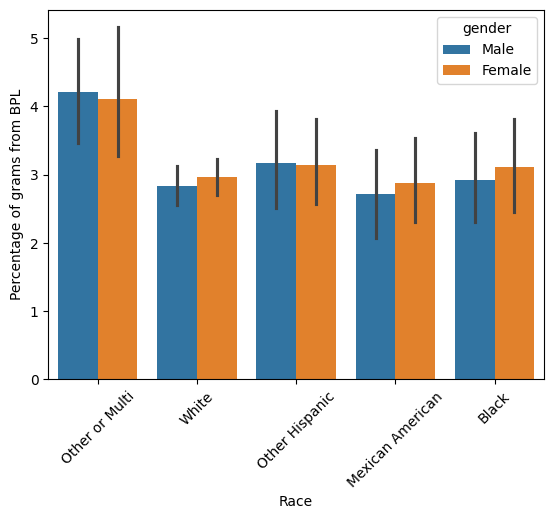

In [344]:
# blp consumption by race
ax = sns.barplot(
  data=dat,
  y='bpl_perc',
  x='race',
  hue='gender',
  weights='dr1_weight',
  errorbar=('ci', 95)
)
ax.set(
  xlabel = 'Race',
  ylabel = 'Percentage of grams from BPL'
)
plt.xticks(rotation=45) 

[Text(0.5, 0, 'Quartiles of Income to Poverty Ratio'),
 Text(0, 0.5, 'Percentage of grams from BPL')]

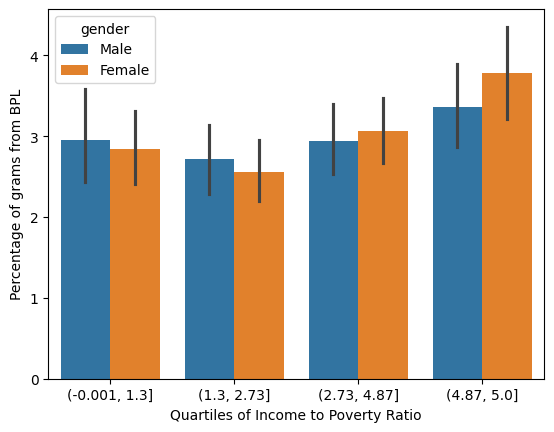

In [345]:
# blp consumption by poverty ratio

ax = sns.barplot(
  data=dat,
  y='bpl_perc',
  x='income_ratio_qs',
  hue='gender',
  weights='dr1_weight',
  errorbar=('ci', 95)
)
ax.set(
  xlabel = 'Quartiles of Income to Poverty Ratio',
  ylabel = 'Percentage of grams from BPL'
)